My first run through this experimentation will be following the model from the paper [Artist Identification with Convulutional Neural Networks](http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf), and working with the [same dataset from Kaggle](https://www.kaggle.com/c/painter-by-numbers). I will initially only be working with a subset of the dataset, train_1.zip, partly due to my ISP's data caps and my current computer setup. In the following month I hope to be able to download more of the data set. I will be using PyTorch for my neural network(s).

UPDATE 06/30/18: I have decided to download the full dataset

In process.py we processed out all of the artists with less than 300 paintings in the dataset so as to ensure that there are sufficient samples for each artist to train on and learn from.

In [1]:
%matplotlib inline

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import common_utils

class BaslineCNN(nn.Module):
    
    def __init__(self):
        super(BaslineCNN, self).__init__()
        # 3 input channels, 64 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,64,3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64,32,3, stride=2, padding=1)
        self.fc1 = nn.Linear(6272,228)
        self.fc2 = nn.Linear(228,common_utils.get_num_artists())
        
        # set decent weight initializations for relu / batch norm
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6272)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
net = BaslineCNN()
    
print(net)

BaslineCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=228, bias=True)
  (fc2): Linear(in_features=228, out_features=38, bias=True)
)


In [2]:
train, test, val = common_utils.get_dataloaders()

[1,    50] loss: 0.890
[1,    50] test accuracy: 6.643
[1,   100] loss: 0.864
[1,   100] test accuracy: 8.714
[1,   150] loss: 0.832
[1,   150] test accuracy: 12.214
[2,    50] loss: 0.808
[2,    50] test accuracy: 13.500
[2,   100] loss: 0.800
[2,   100] test accuracy: 15.071
[2,   150] loss: 0.785
[2,   150] test accuracy: 14.214
[3,    50] loss: 0.775
[3,    50] test accuracy: 13.786
[3,   100] loss: 0.768
[3,   100] test accuracy: 16.714
[3,   150] loss: 0.753
[3,   150] test accuracy: 16.786
[4,    50] loss: 0.739
[4,    50] test accuracy: 17.071
[4,   100] loss: 0.759
[4,   100] test accuracy: 17.714
[4,   150] loss: 0.734
[4,   150] test accuracy: 19.357
[5,    50] loss: 0.734
[5,    50] test accuracy: 19.214
[5,   100] loss: 0.726
[5,   100] test accuracy: 19.786
[5,   150] loss: 0.727
[5,   150] test accuracy: 20.643
[6,    50] loss: 0.719
[6,    50] test accuracy: 20.214
[6,   100] loss: 0.719
[6,   100] test accuracy: 20.500
[6,   150] loss: 0.702
[6,   150] test accuracy: 1

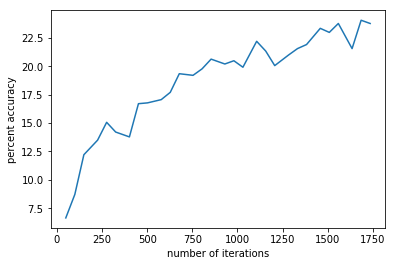

In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt

#make sure we do things on the gpu
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)


test_acc = []
iterations = []
train_len = len(train)

for epoch in range(10):
    
    running_loss = 0
    
    for i, sample in enumerate(train):
        images, labels = sample['images'].cuda(), sample['labels'].cuda()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
            with torch.no_grad():
                total = 0
                correct = 0
                for sample in test:
                    images,labels = sample['images'].cuda(), sample['labels'].cuda()
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                test_acc.append(100*correct/total)
                iterations.append((i+1) + (train_len * epoch))
                print("[%d, %5d] test accuracy: %.3f" % (epoch + 1, i + 1, 100*correct/total))
                    
print('done')

plt.plot(iterations, test_acc)
plt.xlabel('number of iterations')
plt.ylabel('percent accuracy')
plt.show()

Now let's run this model against our test dataset

In [5]:
correct = 0
total = 0
# no grad because we don't want our model to update during testing
with torch.no_grad():
    for sample in val:
        images,labels = sample['images'].cuda(), sample['labels'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 1400 validation images: {0:.2f}'.format(100 * correct/total))

Accuracy of the network on the 1400 validation images: 23.29


Now I want to try adding in batch normalization layers to see the effects.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import common_utils

class BaslineCNNWithBatchNorm(nn.Module):
    
    def __init__(self):
        super(BaslineCNNWithBatchNorm, self).__init__()
        # 3 input channels, 64 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,64,3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64,32,3, stride=2, padding=1)
        self.conv2_bnorm = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(6272,228)
        self.fc1_bnorm = nn.BatchNorm1d(228)
        self.fc2 = nn.Linear(228,common_utils.get_num_artists())
        
        # set decent weight initializations for relu / batch norm
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2_bnorm(self.conv2(x))))
        x = x.view(-1, 6272)
        x = F.relu(self.fc1_bnorm(self.fc1(x)))
        x = self.fc2(x)
        return x        

net = BaslineCNNWithBatchNorm()
    
print(net)

BaslineCNNWithBatchNorm(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=228, bias=True)
  (fc1_bnorm): BatchNorm1d(228, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=228, out_features=38, bias=True)
)


In [2]:
train, test, val = common_utils.get_dataloaders()

[1,    80] loss: 3.346
[1,    80] test accuracy: 13.071
[1,   160] loss: 3.119
[1,   160] test accuracy: 16.643
[2,    80] loss: 2.993
[2,    80] test accuracy: 18.000
[2,   160] loss: 2.887
[2,   160] test accuracy: 20.286
[3,    80] loss: 2.849
[3,    80] test accuracy: 21.714
[3,   160] loss: 2.793
[3,   160] test accuracy: 22.143
[4,    80] loss: 2.757
[4,    80] test accuracy: 24.571
[4,   160] loss: 2.713
[4,   160] test accuracy: 26.429
[5,    80] loss: 2.686
[5,    80] test accuracy: 27.286
[5,   160] loss: 2.628
[5,   160] test accuracy: 27.000
[6,    80] loss: 2.627
[6,    80] test accuracy: 27.786
[6,   160] loss: 2.574
[6,   160] test accuracy: 29.929
[7,    80] loss: 2.564
[7,    80] test accuracy: 29.571
[7,   160] loss: 2.509
[7,   160] test accuracy: 29.071
[8,    80] loss: 2.569
[8,    80] test accuracy: 32.286
[8,   160] loss: 2.463
[8,   160] test accuracy: 29.857
[9,    80] loss: 2.466
[9,    80] test accuracy: 32.143
[9,   160] loss: 2.474
[9,   160] test accuracy:

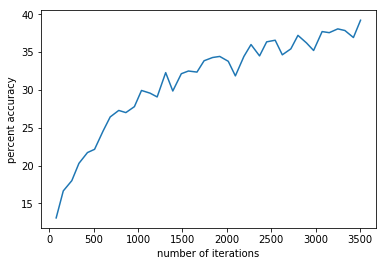

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt

#make sure we do things on the gpu
net.cuda()

#perform initializations better turned to ReLU neurons


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)


test_acc = []
iterations = []
train_len = len(train)

for epoch in range(20):
    
    running_loss = 0
    
    for i, sample in enumerate(train):
        images, labels = sample['images'].cuda(), sample['labels'].cuda()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 80 == 79:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 80))
            running_loss = 0.0
            with torch.no_grad():
                total = 0
                correct = 0
                for sample in test:
                    images,labels = sample['images'].cuda(), sample['labels'].cuda()
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                test_acc.append(100*correct/total)
                iterations.append((i+1) + (train_len * epoch))
                print("[%d, %5d] test accuracy: %.3f" % (epoch + 1, i + 1, 100*correct/total))
                    
print('done')

plt.plot(iterations, test_acc)
plt.xlabel('number of iterations')
plt.ylabel('percent accuracy')
plt.show()

In [4]:
correct = 0
total = 0
# no grad because we don't want our model to update during testing
with torch.no_grad():
    for sample in val:
        images,labels = sample['images'].cuda(), sample['labels'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 1400 validation images: {0:.2f}'.format(100 * correct/total))

Accuracy of the network on the 1400 validation images: 37.43


For a very basic CNN, I think I'm pretty happy with that for now.